# pyforeca: demo on stock data

This notebook is for demonstration purposes of how ForeCA works for analyzing and transforming stock return data.

For stock returns in particular, ForeCA has an obvious application/potential: when constructing a portfolio of stock investments (linear combination of money allocated to stocks) it is beneficial to have predictable returns of the portfolio -- compared to the individual stocks.

This notebook demonstrates how ForeCA can be used to find linear combinations of stocks that are more forecastable, than any individual stock (or other portfolio combination).

See the `README` for details and references.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Not needed if in PATH
import os
import pathlib
parent_path = os.path.join(os.getcwd(), "..")

import sys
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

# Load relevant modules

In [3]:
import importlib
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import pyforeca
from pyforeca.datasets import reader
from pyforeca import viz
from pyforeca import spectral
from pyforeca import optimizer

In [5]:
# for Welch estimation
_NPERSEG = 256

# Load data: stock market return example

In [6]:
df = reader.load_eu_stock_markets_data()

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'DAX'}>, <Axes: title={'center': 'SMI'}>,
        <Axes: title={'center': 'CAC'}>,
        <Axes: title={'center': 'FTSE'}, xlabel='Time'>], dtype=object))

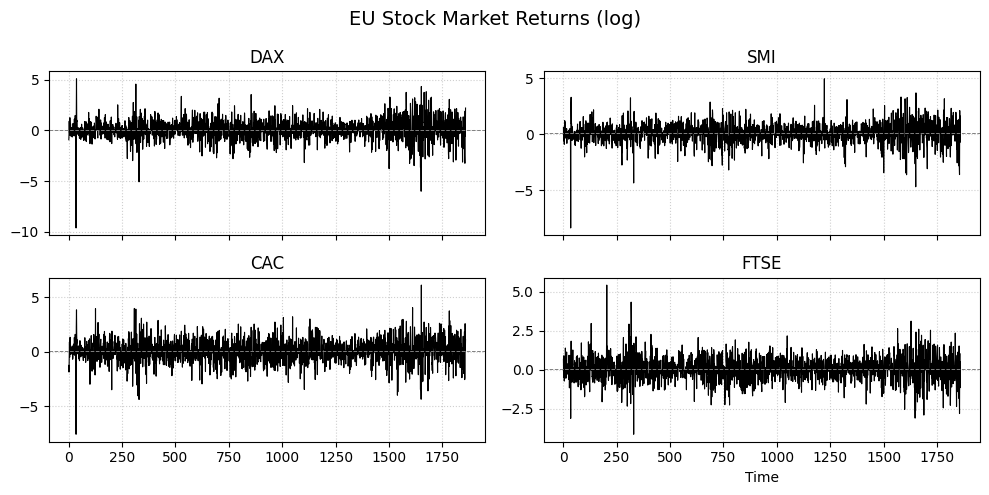

In [7]:
log_returns = df.apply(np.log).diff().dropna() * 100
viz.plot_time_series(log_returns, title="EU Stock Market Returns (log)", n_cols=2)

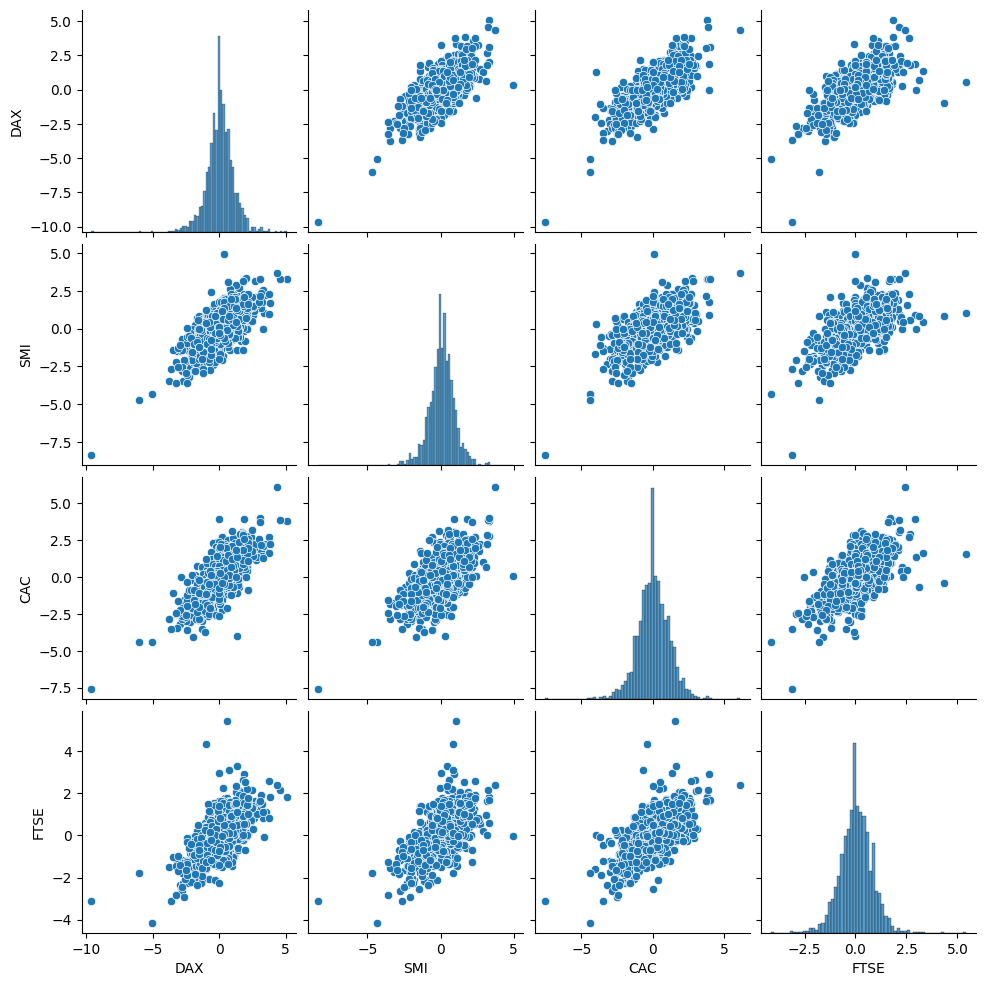

In [8]:
sns.pairplot(data=log_returns)

The 4 stock index returns here have all the typical stylized facts: skewness and heavy tails, and mostly uncorrelated over time.

However, clearly stock markets in different countries are heavily correlated by worldly events and global economic developments.

**Note:** If you want to better model skewness and heavy-tails of stock returns, take a look at [`https://github.com/gmgeorg/pylambertw`](https://github.com/gmgeorg/pylambertw) to remove heavy-tails from stock return data.  For the ForeCA tutorial we continue to use original data with skewness and heavy-tails.

In [9]:
corr = log_returns.corr()
part_corr = pyforeca.utils.partial_corr(log_returns)

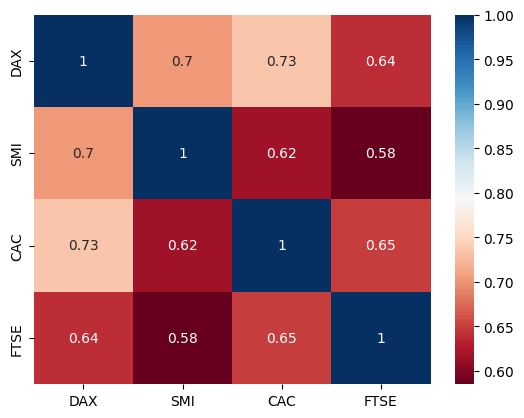

<Axes: >

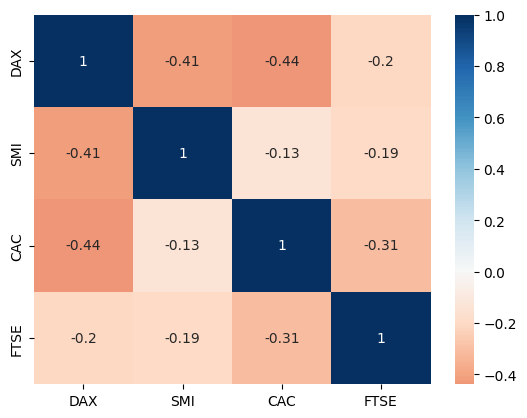

In [10]:
sns.heatmap(corr, annot=True, cmap="RdBu")
plt.show()
sns.heatmap(part_corr, annot=True, cmap="RdBu", center=0.)

In [11]:
model = pyforeca.base.ForeCA(
    spectrum_method="welch",
    nperseg=_NPERSEG,
    max_iter=200,
    tol=1e-8,
)
model.fit(log_returns)

Finding ForeC 4 ...


ForeCA(max_iter=200, n_components=4, nperseg=256)

(<Figure size 750x600 with 1 Axes>, <Axes: xlabel='ForeC1', ylabel='ForeC2'>)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


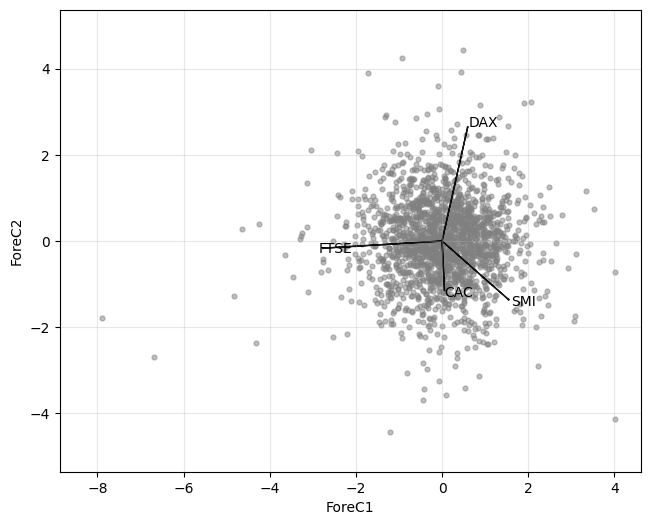

In [12]:
viz.biplot(model, log_returns)


ForeCA found the top 4 ForeCs of shape (1859, 4)
Ω(ForeC i) in % (higher is more forecastable):
forec1    0.015301
forec2    0.010880
forec3    0.010368
forec4    0.006928
Name: omega, dtype: float64


<Axes: >

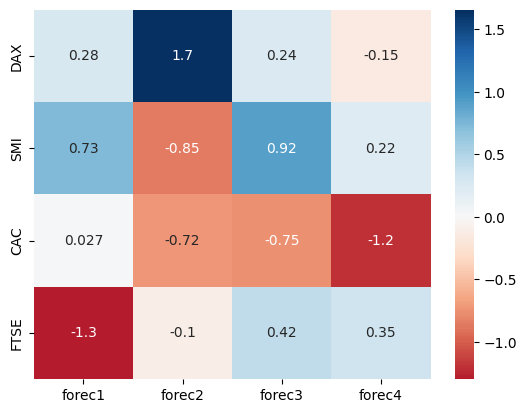

In [13]:
fc_log_returns = model.transform(log_returns)  # ForeC scores (uncorrelated, zero-mean, unit variance)

print(f"\nForeCA found the top {fc_log_returns.shape[1]} ForeCs of shape {fc_log_returns.shape}")
print("Ω(ForeC i) in % (higher is more forecastable):")
print(model.omegas_)

sns.heatmap(model.components_, cmap="RdBu", center=0., annot=True)


In [14]:
print("\nMean of scores:", np.round(fc_log_returns.mean(axis=0), 3))
print("Cov(scores):\n", np.round(fc_log_returns.cov(), 3))


Mean of scores: forec1    0.0
forec2   -0.0
forec3    0.0
forec4    0.0
dtype: float64
Cov(scores):
         forec1  forec2  forec3  forec4
forec1     1.0    -0.0     0.0     0.0
forec2    -0.0     1.0     0.0     0.0
forec3     0.0     0.0     1.0    -0.0
forec4     0.0     0.0    -0.0     1.0


<Axes: xlabel='frequency', ylabel='PSD'>

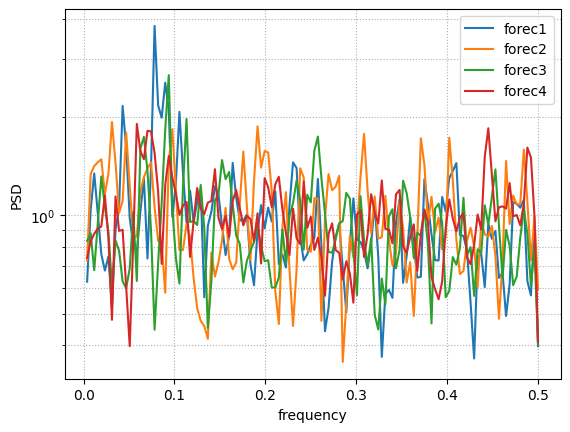

In [15]:
mvspec_y = spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(fc_log_returns).mvspectrum_
mvspec_y.plot()

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'forec1'}>,
        <Axes: title={'center': 'forec2'}>,
        <Axes: title={'center': 'forec3'}>,
        <Axes: title={'center': 'forec4'}, xlabel='Time'>], dtype=object))

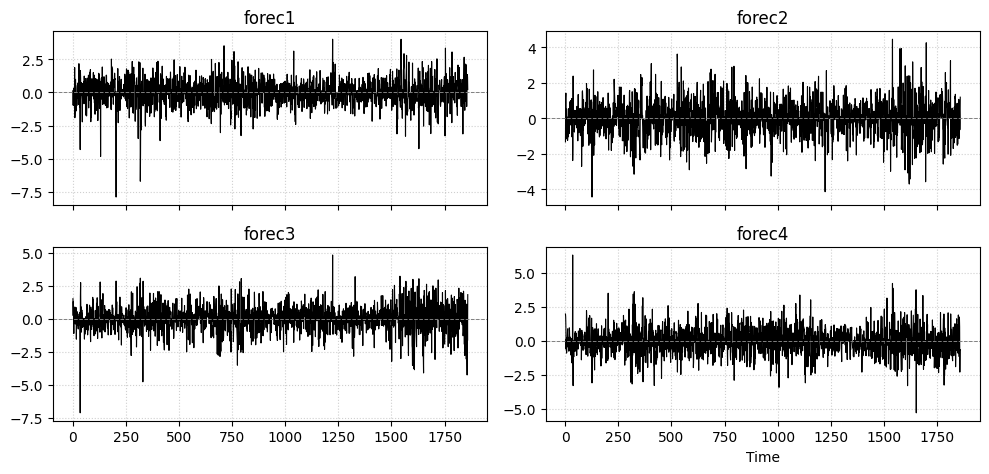

In [16]:
viz.plot_time_series(fc_log_returns, n_cols=2)

<Axes: xlabel='lag', ylabel='ACF'>

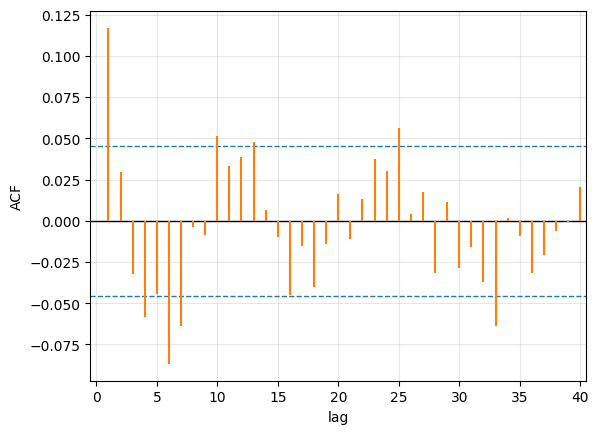

In [17]:
viz.plot_acf(fc_log_returns.iloc[:, 0])

<Axes: xlabel='lag', ylabel='ACF'>

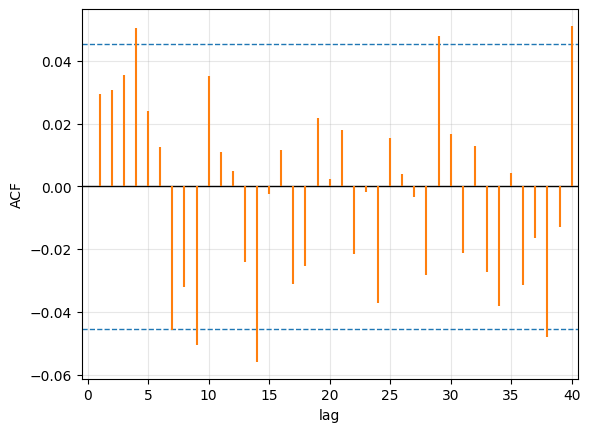

In [18]:
viz.plot_acf(fc_log_returns.iloc[:, 1])

(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Forecastability (ForeCs)'}, ylabel='Ω (%)'>,
         <Axes: title={'center': 'Forecastability (X)'}>],
        [<Axes: title={'center': 'White-noise test p-value (ForeCs)'}, ylabel='p-value'>,
         <Axes: title={'center': 'White-noise test p-value (original)'}, ylabel='p-value'>]],
       dtype=object))

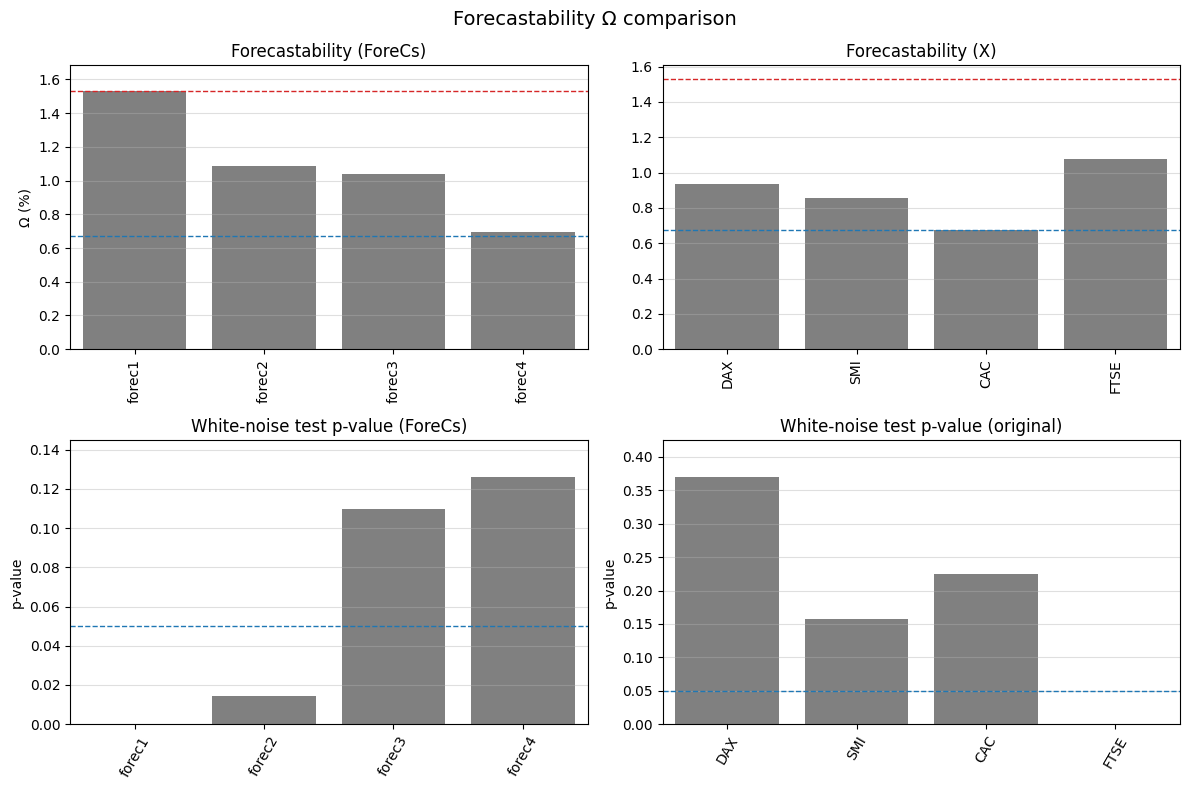

In [20]:
viz.plot_foreca(model, X=log_returns, add_white_noise_test=True)

<Axes: xlabel='frequency', ylabel='PSD'>

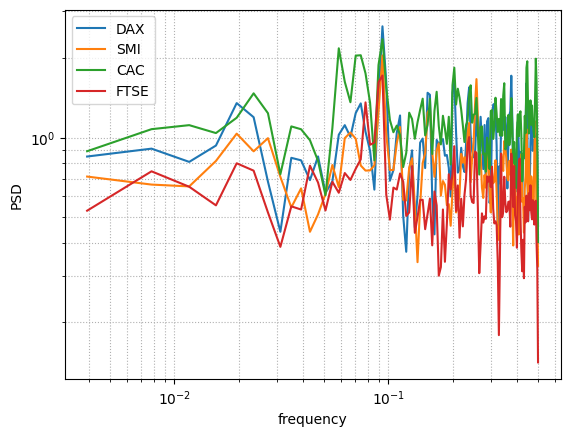

In [21]:
spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(log_returns).mvspectrum_.plot(log_x=True)

<Axes: xlabel='frequency', ylabel='PSD'>

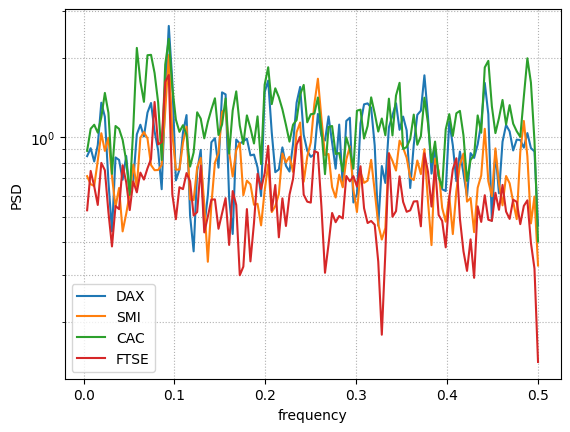

In [22]:
spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(log_returns).mvspectrum_.plot(log_x=False)

In [23]:
spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(log_returns).mvspectrum_.normalize_whiten().omegas()

DAX     0.009739
SMI     0.009016
CAC     0.007515
FTSE    0.013691
Name: omega, dtype: float64